In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import sys
sys.path.append("../Question-2_Autoencoders")

import torch
import torch.optim as optim
from torch.utils.data import DataLoader, SubsetRandomSampler
import torchvision
from torchvision import transforms
import os
from datetime import datetime  # For generating timestamped folder names
from tqdm.auto import tqdm
from CNN_autoencoder_model import *

In [4]:
# Check if GPU is available, otherwise use CPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Use the saved model weights

In [5]:
lambda_2_cnn_autoencoder = CNNAutoencoder(2)
lambda_32_cnn_autoencoder = CNNAutoencoder(32)

best_lambda_2_model_path = "../Question-2_Autoencoders/model_ckpts_CNN/2/model_epoch_30.pt"
checkpoint_lambda_2 = torch.load(best_lambda_2_model_path)

best_lambda_32_model_path = "../Question-2_Autoencoders/model_ckpts_CNN/32/model_epoch_30.pt"
checkpoint_lambda_32 = torch.load(best_lambda_32_model_path)

lambda_2_cnn_autoencoder.load_state_dict(checkpoint_lambda_2['model_state_dict'])
lambda_32_cnn_autoencoder.load_state_dict(checkpoint_lambda_32['model_state_dict'])

#move it to GPU
lambda_2_cnn_autoencoder.to(device)
lambda_32_cnn_autoencoder.to(device)

CNNAutoencoder(
  (encoder): CNNEncoder(
    (encoder): Sequential(
      (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU()
      (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (3): Conv2d(16, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (4): ReLU()
      (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    )
    (fc1): Sequential(
      (0): Linear(in_features=392, out_features=392, bias=True)
      (1): ReLU()
    )
    (fc2): Sequential(
      (0): Linear(in_features=392, out_features=32, bias=True)
      (1): ReLU()
    )
  )
  (decoder): CNNDecoder(
    (decoder): Sequential(
      (0): Linear(in_features=32, out_features=392, bias=True)
      (1): ReLU()
      (2): Unflatten(dim=1, unflattened_size=(8, 7, 7))
      (3): ConvTranspose2d(8, 8, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
      (4): ReLU()
      (5): ConvTranspose2d(8, 16, kernel_size=(3, 

# Load the mnist data

In [6]:
# Load MNIST dataset and apply transformations
transform = transforms.Compose([transforms.ToTensor()])
mnist_dataset = torchvision.datasets.MNIST(root='./data', train=True, transform=transform, download=True)
train_loader = DataLoader(mnist_dataset, batch_size=1, shuffle=False)

# Now pass the whole dataset through the encoder and get the latent embeddings

### First lets see lambda = 2

In [20]:
#set in eval mode
lambda_2_cnn_autoencoder.encoder.eval()
lambda_2_cnn_autoencoder.decoder.eval()

lambda_2_all_latent_features = []

with torch.no_grad():
    for batch_idx, data in tqdm(enumerate(train_loader)):
        images, _ = data
        images = images.to(device)
        # Forward pass through the model
        latent_features_batch = lambda_2_cnn_autoencoder.encoder(images)
        lambda_2_all_latent_features.append(latent_features_batch)


0it [00:00, ?it/s]

In [23]:
lambda_2_avg_latent_feature = sum(lambda_2_all_latent_features)/len(mnist_dataset)
reconstructed_lambda_2 = lambda_2_cnn_autoencoder.decoder(lambda_2_avg_latent_feature)

# First lets see lambda = 32

In [24]:
#set in eval mode
lambda_32_cnn_autoencoder.encoder.eval()
lambda_32_cnn_autoencoder.decoder.eval()

lambda_32_all_latent_features = []

with torch.no_grad():
    for batch_idx, data in tqdm(enumerate(train_loader)):
        images, _ = data
        images = images.to(device)
        # Forward pass through the model
        latent_features_batch = lambda_32_cnn_autoencoder.encoder(images)
        lambda_32_all_latent_features.append(latent_features_batch)


0it [00:00, ?it/s]

In [25]:
lambda_32_avg_latent_feature = sum(lambda_32_all_latent_features)/len(mnist_dataset)
reconstructed_lambda_32 = lambda_32_cnn_autoencoder.decoder(lambda_32_avg_latent_feature)

# Lets now plot the reconstructed images

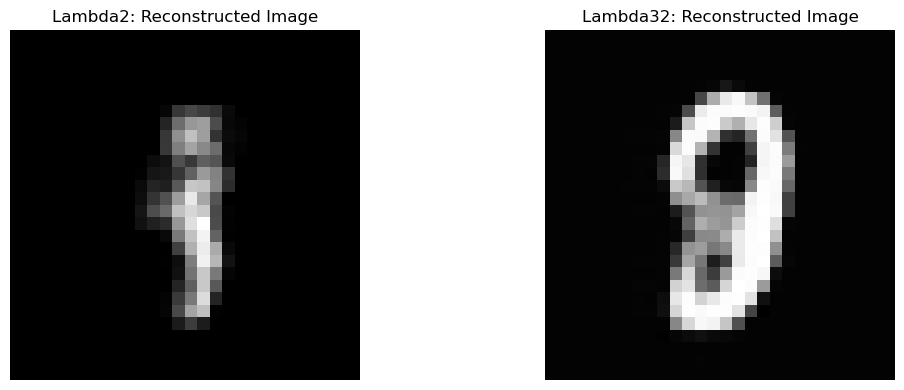

In [29]:
import matplotlib.pyplot as plt

# Create a subplot grid
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# Plot original image
axes[0].imshow(reconstructed_lambda_2.squeeze().cpu().detach().numpy(), cmap='gray')
axes[0].set_title('Lambda2: Reconstructed Image')
axes[0].axis('off')

# Plot reconstructed image
axes[1].imshow(reconstructed_lambda_32.squeeze().cpu().detach().numpy(), cmap='gray')
axes[1].set_title('Lambda32: Reconstructed Image')
axes[1].axis('off')

plt.tight_layout()
plt.show()


# Interpretation


For both images since we are taking the average of all latent features for the entire training dataset there will be some kind of blurring effect in the reconstructed image as in some sense we are finding a compromise between all input digits and trying to find the most "average" looking digit. Additionally , we can see that the images are lacking clarity as well as we cannot clearly classify this reconstruction as belonging to one particular class.

In case of lambda 2 since the model itself is not that powerful it has only learnt the most basic features which is why the blurred reconstruction image just shows the parts which is common in most digits. ( which in this case is most probably the right hand side line present in numbers like 7 and 9 etc)

However, in the case of lambda 32 model it has learnt that the most "average looking" number is something which looks like an 8 which makes sense since in most digital clocks all digits can be representable using the parts of the digit "8".

This kind of high level/abstract concept would have been learnt across all the handwritten digits in the dataset.

